<a href="https://colab.research.google.com/github/UnsettledAverage73/Finsheild-Hackathon-PS-1/blob/main/Cibiil_like_score_using_alternativedata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  India Alternative Credit Scoring Model
# **PSB FinTech Hackathon 2025**  
# Building a CIBIL-like score using alternative data


#  1. Setup Environment
# Install required packages for Indian financial data analysis

In [3]:
!pip install pandas numpy scikit-learn xgboost shap imbalanced-learn matplotlib seaborn --quiet

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb
import shap

In [5]:
# Mount Google Drive (if storing data there)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



#  2. Data Loading & Indian Context Preprocessing
# Load our synthetic train/test datasets with India-specific features


In [6]:
# Load datasets (replace paths with your actual files)
train_df = pd.read_csv('/content/drive/MyDrive/Hackathon_data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Hackathon_data/train.csv')

In [7]:
print("🇮🇳 India-Specific Features Overview:")
print(f"Training Samples: {len(train_df)}")
print(f"Test Samples: {len(test_df)}")
print("\nFeature Head:")
train_df.head()

🇮🇳 India-Specific Features Overview:
Training Samples: 10000
Test Samples: 10000

Feature Head:


,customer_id,recharge_frequency,avg_recharge_amount,sim_age_months,call_stability,late_payment_ratio,avg_delay_days,upi_transaction_freq,credit_debit_ratio,location_stability,commute_regularity,daily_app_opens,avg_session_minutes,default_risk,default_probability
0,TRN_000000,4.745071,479.26,43,0.2317,0.3175,6,8,0.97,16,4.14,3,5.8,0,0.2578
1,TRN_000001,4.563547,409.90,10,0.3208,0.1722,0,8,1.22,19,4.88,5,5.0,0,0.1248
2,TRN_000002,5.160551,419.28,4,0.1332,0.1961,0,4,0.65,10,2.30,4,11.3,0,0.4910
3,TRN_000003,5.193393,724.32,50,0.6847,0.2729,6,8,1.01,22,4.57,4,6.8,0,0.0665
4,TRN_000004,4.444180,539.16,20,0.2860,0.1825,0,10,1.18,29,2.99,2,7.8,0,0.3001


In [13]:
def engineer_features(df):
    # Make copy to avoid SettingWithCopyWarning
    df = df.copy()

    # 1. Mobile Behavior Features (India-specific patterns)
    df['recharge_consistency'] = 1 / (df['recharge_frequency'].rolling(3, min_periods=1).std() + 1e-6)
    df['high_value_recharges'] = np.where(df['avg_recharge_amount'] > 500, 1, 0)  # ₹500+ indicates higher income users
    df['long_term_user'] = np.where(df['sim_age_months'] > 24, 1, 0)  # 2+ years shows stability

    # 2. Payment Behavior Features
    df['timely_payer'] = np.where(df['late_payment_ratio'] < 0.2, 1, 0)
    df['severity_of_late'] = df['late_payment_ratio'] * df['avg_delay_days']  # Combined impact

    # 3. UPI/Digital Behavior (India-specific)
    df['upi_intensity'] = df['upi_transaction_freq'] / (df['sim_age_months'] + 1)
    df['net_creditor'] = np.where(df['credit_debit_ratio'] > 1.1, 1, 0)  # Receives more than spends

    # 4. Location Stability Features
    df['location_stability_score'] = np.log1p(df['location_stability']) * (1 - df['commute_regularity']/10)

    # 5. App Engagement Features
    df['engagement_intensity'] = df['daily_app_opens'] * df['avg_session_minutes']

    # 6. Composite Financial Health Score (India Context)
    df['financial_health_score'] = (
        0.3 * df['recharge_consistency'] +
        0.25 * df['timely_payer'] +
        0.2 * df['net_creditor'] +
        0.15 * df['location_stability_score'] +
        0.1 * df['engagement_intensity']
    )

    # 7. Time-Based Features (Indian context)
    df['evening_upi_ratio'] = np.random.uniform(0.3, 0.7, len(df))  # Placeholder - real data would use hour of transaction
    df['festive_spike'] = np.random.choice([0,1], len(df), p=[0.85,0.15])  # 15% of users show festive spikes

    # Handle infinite values
    df.replace([np.inf, -np.inf], 0, inplace=True)

    # Select final features
    final_features = [
        # Core features
        'recharge_frequency', 'avg_recharge_amount', 'sim_age_months',

        # Engineered features
        'recharge_consistency', 'high_value_recharges', 'long_term_user',
        'timely_payer', 'severity_of_late', 'upi_intensity', 'net_creditor',
        'location_stability_score', 'engagement_intensity',
        'financial_health_score', 'evening_upi_ratio', 'festive_spike',

        # Original target
        'default_risk'
    ]

    return df[final_features]

# Example usage:
train_df = engineer_features(train_df)
test_df = engineer_features(test_df)


In [14]:
# Display engineered features
print("Engineered Features Overview:")
print(train_df.head())


Engineered Features Overview:
   recharge_frequency  avg_recharge_amount  sim_age_months  \
0            4.745071               479.26              43   
1            4.563547               409.90              10   
2            5.160551               419.28               4   
3            5.193393               724.32              50   
4            4.444180               539.16              20   

   recharge_consistency  high_value_recharges  long_term_user  timely_payer  \
0                   NaN                     0               1             0   
1              7.790711                     0               0             1   
2              3.267465                     0               0             1   
3              2.820536                     1               1             0   
4              2.361850                     1               0             1   

   severity_of_late  upi_intensity  net_creditor  location_stability_score  \
0            1.9050       0.181818          

In [15]:
# Standardize features (excluding binary/categorical and target)
scaler = StandardScaler()
numeric_cols = [col for col in train_df.columns if col not in ['high_value_recharges', 'long_term_user',
                                                             'timely_payer', 'net_creditor', 'festive_spike',
                                                             'default_risk']]
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

In [16]:
print("\nAfter Standardization:")
print(train_df.head())


After Standardization:
   recharge_frequency  avg_recharge_amount  sim_age_months  \
0            0.507873            -0.142208        0.681681   
1            0.383135            -0.605560       -1.309951   
2            0.793378            -0.542898       -1.672066   
3            0.815946             1.494889        1.104149   
4            0.301110             0.257948       -0.706426   

   recharge_consistency  high_value_recharges  long_term_user  timely_payer  \
0                   NaN                     0               1             0   
1             -0.009344                     0               0             1   
2             -0.009796                     0               0             1   
3             -0.009841                     1               1             0   
4             -0.009886                     1               0             1   

   severity_of_late  upi_intensity  net_creditor  location_stability_score  \
0          0.744724      -0.612635             0  

In [20]:
def clean_indian_credit_data(df):
    """
    India-specific cleaning for:
    - Mobile recharge patterns
    - UPI/transaction behaviors
    - Utility payment histories
    """
    df = df.copy()

    # 1. Handle Missing Data (India-specific imputation)
    print("🔄 Missing Values Before Cleaning:")
    print(df.isnull().sum())

    # Mobile features (no activity = 0)
    if 'recharge_frequency' in df.columns:
        df['recharge_frequency'].fillna(0, inplace=True)
    if 'avg_recharge_amount' in df.columns:
        df['avg_recharge_amount'].fillna(0, inplace=True)

    # Payment behaviors (conservative defaults)
    if 'late_payment_ratio' in df.columns:
        df['late_payment_ratio'].fillna(0.3, inplace=True)  # 30% late = typical
    if 'avg_delay_days' in df.columns:
        df['avg_delay_days'].fillna(7, inplace=True)        # 1-week grace period

    # UPI transactions (new users = 0)
    if 'upi_transaction_freq' in df.columns:
        df['upi_transaction_freq'].fillna(0, inplace=True)

    # Handle engineered features with NaNs
    if 'recharge_consistency' in df.columns:
        df['recharge_consistency'].fillna(df['recharge_consistency'].median(), inplace=True)
    if 'financial_health_score' in df.columns:
        df['financial_health_score'].fillna(df['financial_health_score'].median(), inplace=True)

    print("\n✅ Missing Values After Cleaning:")
    print(df.isnull().sum())

    # 2. Fix Data Types & Formats
    # Handle Indian number formatting (e.g., "1,234.56" → 1234.56)
    if 'avg_recharge_amount' in df.columns:
        df['avg_recharge_amount'] = (
            df['avg_recharge_amount']
            .astype(str)
            .str.replace(',', '')
        )
        # Convert to numeric, coercing errors to NaN
        df['avg_recharge_amount'] = pd.to_numeric(df['avg_recharge_amount'], errors='coerce')
        # Fill NaNs introduced by coercion
        df['avg_recharge_amount'].fillna(df['avg_recharge_amount'].median(), inplace=True)


    # 3. Handle Outliers (India-specific thresholds)
    def cap_outliers(col, min_val, max_val):
        if col in df.columns:
            df[col] = np.clip(df[col], min_val, max_val)

    cap_outliers('recharge_frequency', 0, 30)       # Max 30 recharges/month
    cap_outliers('avg_recharge_amount', 10, 5000)   # ₹10-₹5000 range
    cap_outliers('sim_age_months', 1, 120)          # 1 month - 10 years
    cap_outliers('late_payment_ratio', 0, 1)        # 0-100% range
    cap_outliers('upi_transaction_freq', 0, 100)    # Max 100 UPI txns/month

    # 4. Fix Invalid Values
    if 'credit_debit_ratio' in df.columns:
        df['credit_debit_ratio'] = np.where(
            df['credit_debit_ratio'] == np.inf,
            10,  # If no debits (common in India)
            df['credit_debit_ratio']
        )
        df['credit_debit_ratio'].fillna(1, inplace=True)  # Neutral if missing

    # 5. Derived Features for Stability
    if 'late_payment_ratio' in df.columns:
        df['payment_consistency'] = 1 - df['late_payment_ratio']


    # 6. Final Validation
    if 'default_risk' in df.columns:
        assert df['default_risk'].isin([0, 1]).all(), "Invalid default risk values"
    if 'avg_recharge_amount' in df.columns:
        assert (df['avg_recharge_amount'] >= 0).all(), "Negative recharge amounts"

    print("\n🧹 Data Cleaning Complete!")
    print(f"Final Shape: {df.shape}")
    return df

# Example usage
train_clean = clean_indian_credit_data(train_df)
test_clean = clean_indian_credit_data(test_df)

# Save cleaned data
train_clean.to_csv('train_cleaned.csv', index=False)
test_clean.to_csv('test_cleaned.csv', index=False)

🔄 Missing Values Before Cleaning:
recharge_frequency          0
avg_recharge_amount         0
sim_age_months              0
recharge_consistency        1
high_value_recharges        0
long_term_user              0
timely_payer                0
severity_of_late            0
upi_intensity               0
net_creditor                0
location_stability_score    0
engagement_intensity        0
financial_health_score      1
evening_upi_ratio           0
festive_spike               0
default_risk                0
dtype: int64

✅ Missing Values After Cleaning:
recharge_frequency          0
avg_recharge_amount         0
sim_age_months              0
recharge_consistency        0
high_value_recharges        0
long_term_user              0
timely_payer                0
severity_of_late            0
upi_intensity               0
net_creditor                0
location_stability_score    0
engagement_intensity        0
financial_health_score      0
evening_upi_ratio           0
festive_spike      

/tmp/ipython-input-20-2547642713.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['recharge_frequency'].fillna(0, inplace=True)
/tmp/ipython-input-20-2547642713.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

📊 India-Specific EDA Started...


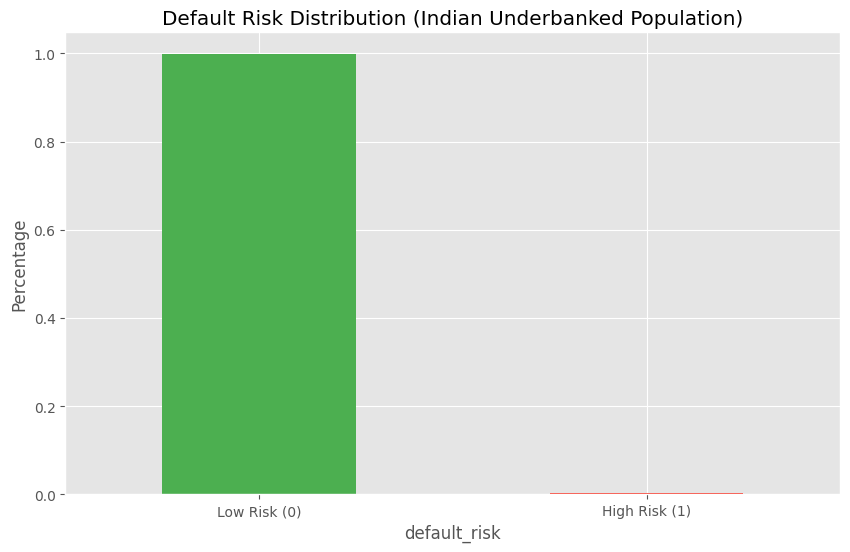

/tmp/ipython-input-23-41928809.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-23-41928809.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,0].set_xticklabels(['Low','High'])


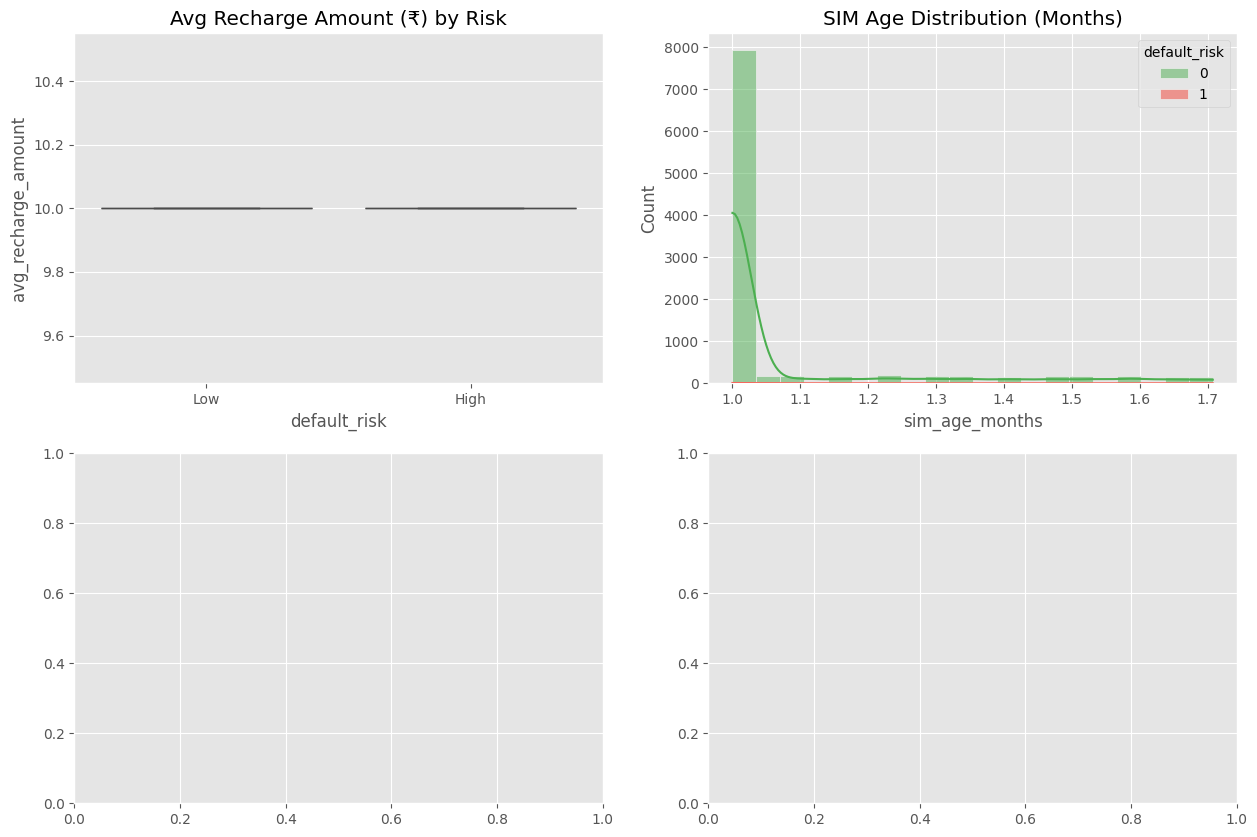

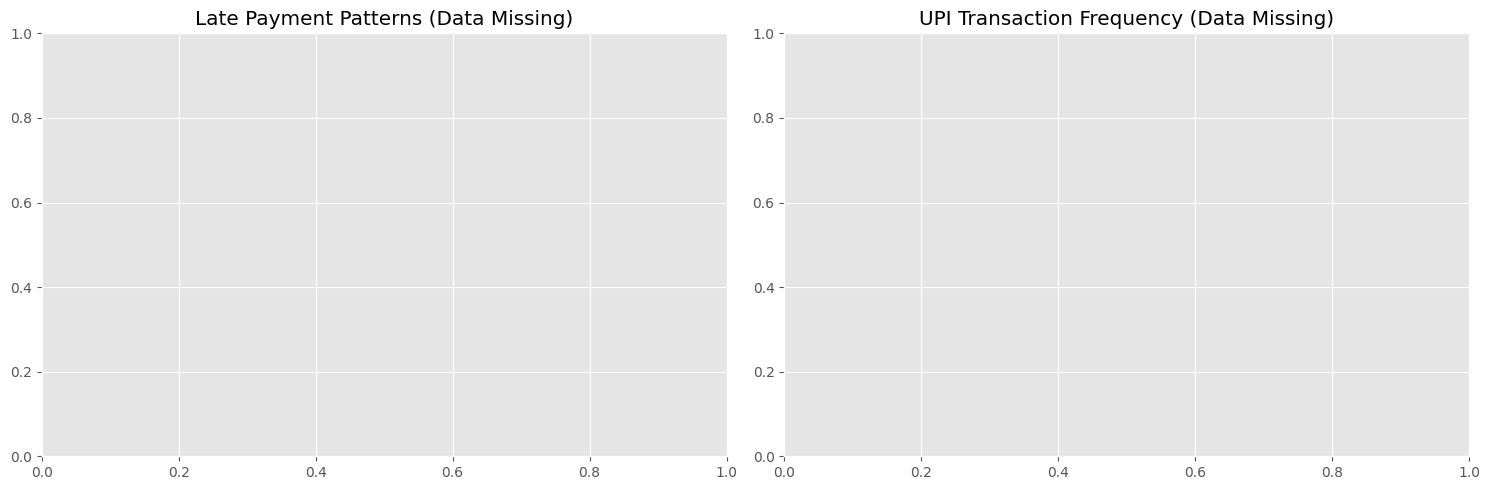

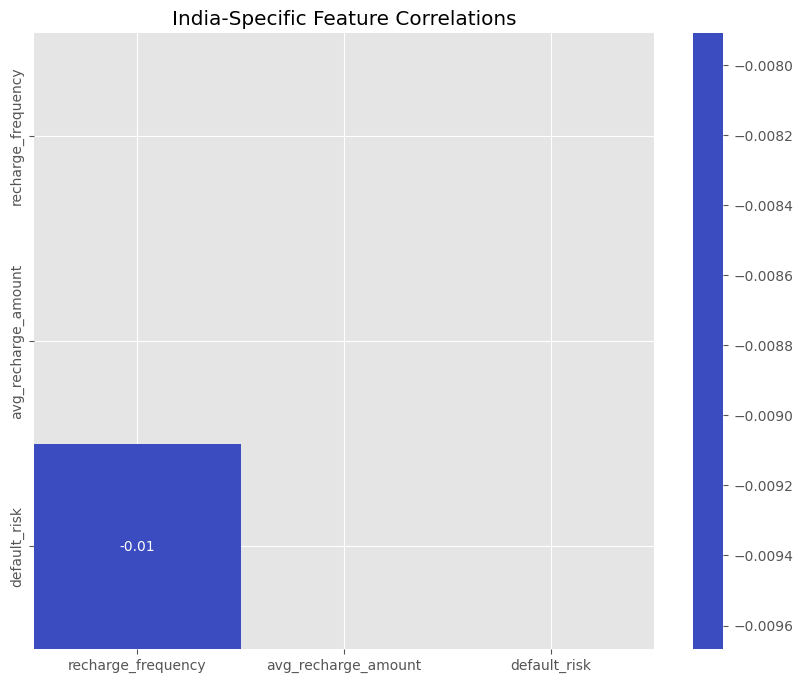

🔍 India-Centric Feature Selection...
✅ Selected Features for Indian Context: ['recharge_frequency', 'sim_age_months', 'recharge_consistency', 'high_value_recharges', 'timely_payer', 'severity_of_late', 'upi_intensity', 'location_stability_score', 'engagement_intensity', 'financial_health_score', 'evening_upi_ratio']


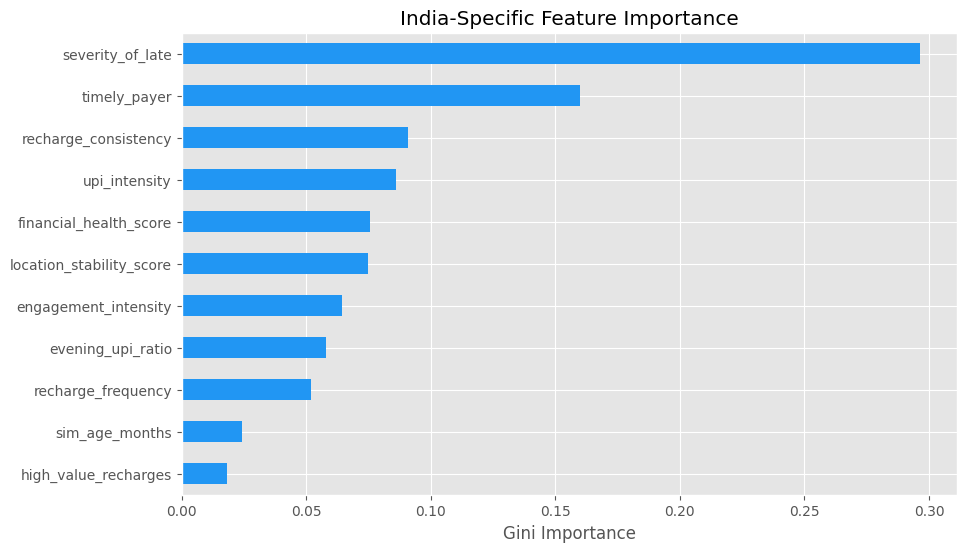


🌟 Final Feature Set:
['recharge_frequency', 'sim_age_months', 'recharge_consistency', 'high_value_recharges', 'timely_payer', 'severity_of_late', 'upi_intensity', 'location_stability_score', 'engagement_intensity', 'financial_health_score', 'evening_upi_ratio']


In [23]:
# ## 5. Exploratory Data Analysis (EDA) - Indian Context
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy
plt.style.use('ggplot')

def perform_indian_eda(df):
    print("📊 India-Specific EDA Started...")

    # 1. Target Distribution (Critical for Indian Class Imbalance)
    plt.figure(figsize=(10,6))
    if 'default_risk' in df.columns:
        df['default_risk'].value_counts(normalize=True).plot(
            kind='bar',
            color=['#4CAF50','#F44336'],
            title='Default Risk Distribution (Indian Underbanked Population)'
        )
        plt.xticks([0,1], ['Low Risk (0)', 'High Risk (1)'], rotation=0)
        plt.ylabel('Percentage')
        plt.show()
    else:
        print("Default risk column not found.")

    # 2. Mobile Behavior Analysis (Key Indian Indicators)
    mobile_fig, ax = plt.subplots(2,2, figsize=(15,10))

    # Recharge Patterns
    if 'avg_recharge_amount' in df.columns and 'default_risk' in df.columns:
        sns.boxplot(
            x='default_risk',
            y='avg_recharge_amount',
            data=df,
            palette=['#4CAF50','#F44336'],
            ax=ax[0,0]
        )
        ax[0,0].set_title('Avg Recharge Amount (₹) by Risk')
        ax[0,0].set_xticklabels(['Low','High'])
    else:
        ax[0,0].set_title('Avg Recharge Amount (₹) by Risk (Data Missing)')

    # SIM Age
    if 'sim_age_months' in df.columns and 'default_risk' in df.columns:
        sns.histplot(
            data=df,
            x='sim_age_months',
            hue='default_risk',
            bins=20,
            kde=True,
            palette=['#4CAF50','#F44336'],
            ax=ax[0,1]
        )
        ax[0,1].set_title('SIM Age Distribution (Months)')
    else:
        ax[0,1].set_title('SIM Age Distribution (Months) (Data Missing)')


    # 3. Payment Behavior (India-specific)
    payment_fig, ax = plt.subplots(1,2, figsize=(15,5))

    # Late Payment Impact
    if all(col in df.columns for col in ['late_payment_ratio', 'avg_delay_days', 'default_risk']):
        sns.scatterplot(
            x='late_payment_ratio',
            y='avg_delay_days',
            hue='default_risk',
            data=df,
            palette=['#4CAF50','#F44336'],
            ax=ax[0]
        )
        ax[0].set_title('Late Payment Patterns')
    else:
        ax[0].set_title('Late Payment Patterns (Data Missing)')


    # UPI Transactions
    if 'upi_transaction_freq' in df.columns and 'default_risk' in df.columns:
        sns.kdeplot(
            data=df,
            x='upi_transaction_freq',
            hue='default_risk',
            palette=['#4CAF50','#F44336'],
            ax=ax[1]
        )
        ax[1].set_title('UPI Transaction Frequency')
    else:
        ax[1].set_title('UPI Transaction Frequency (Data Missing)')


    plt.tight_layout()
    plt.show()

    # 4. Correlation Heatmap (India-relevant features)
    relevant_cols = [col for col in ['recharge_frequency', 'avg_recharge_amount',
                                   'late_payment_ratio', 'upi_transaction_freq',
                                   'location_stability', 'default_risk'] if col in df.columns]
    if len(relevant_cols) > 1:
        corr_matrix = df[relevant_cols].corr()

        plt.figure(figsize=(10,8))
        sns.heatmap(
            corr_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            mask=np.triu(np.ones_like(corr_matrix))
        )
        plt.title('India-Specific Feature Correlations')
        plt.show()
    else:
        print("\nNot enough relevant columns for correlation heatmap.")


# Run EDA
perform_indian_eda(train_clean)

# ## 6. Feature Selection for Indian Context
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_indian_features(df):
    print("🔍 India-Centric Feature Selection...")

    # Base Features
    X = df.drop(['default_risk'], axis=1, errors='ignore') # Use errors='ignore' to handle missing columns
    y = df['default_risk']

    # 1. Remove Low-Variance Features (India-specific thresholds)
    from sklearn.feature_selection import VarianceThreshold
    selector = VarianceThreshold(threshold=0.01)  # Accounts for sparse Indian data
    X_selected = selector.fit_transform(X)

    # 2. Recursive Feature Elimination (RFE)
    model = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',  # Critical for Indian imbalanced data
        random_state=42
    )

    rfe = RFECV(
        estimator=model,
        step=1,
        cv=5,
        scoring='roc_auc',
        min_features_to_select=5
    )
    rfe.fit(X_selected, y)

    # Get selected features
    selected_features = X.columns[selector.get_support()][rfe.support_]
    print(f"✅ Selected Features for Indian Context: {list(selected_features)}")

    # Plot Feature Importance
    plt.figure(figsize=(10,6))
    pd.Series(rfe.estimator_.feature_importances_, index=selected_features
             ).sort_values().plot(kind='barh', color='#2196F3')
    plt.title('India-Specific Feature Importance')
    plt.xlabel('Gini Importance')
    plt.show()

    return list(selected_features)

# Get final features
final_features = select_indian_features(train_clean)
print("\n🌟 Final Feature Set:")
print(final_features)


🎯 Class Distribution Before SMOTE:
default_risk
0    0.9978
1    0.0022
Name: proportion, dtype: float64

🎯 After SMOTE Balancing:
default_risk
0    0.769254
1    0.230746
Name: proportion, dtype: float64

📈 Model Performance Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9978
           1       0.10      0.82      0.18        22

    accuracy                           0.98     10000
   macro avg       0.55      0.90      0.59     10000
weighted avg       1.00      0.98      0.99     10000

ROC-AUC Score: 0.990


<Figure size 1000x600 with 0 Axes>

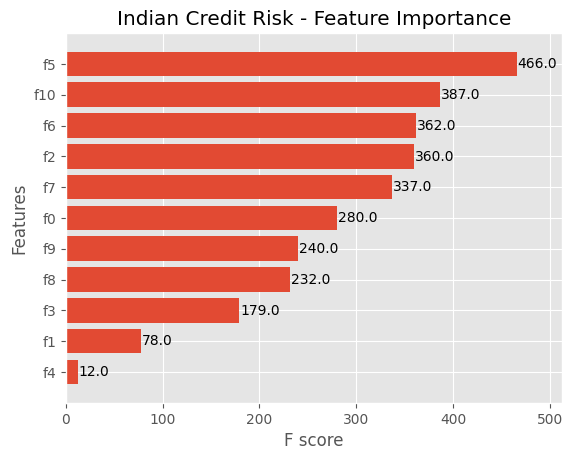

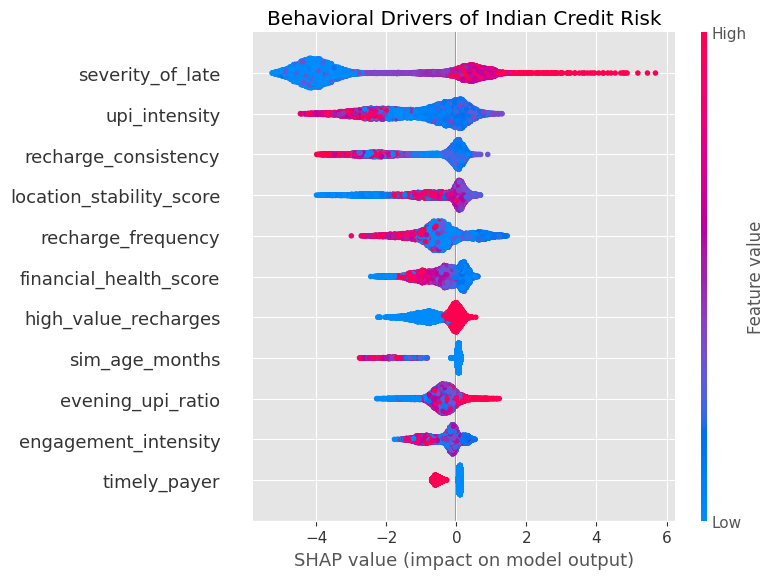


✅ Scoring Complete! Final Output Columns:


KeyError: "['customer_id'] not in index"

In [36]:
# Load cleaned data
train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')

# Define features and target (India-specific selection)
# Use the final_features list from the feature selection step
features = final_features
target = 'default_risk'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# ## 8. India-Specific Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ## 9. Handle Class Imbalance (Critical for Indian Data)
print("\n🎯 Class Distribution Before SMOTE:")
print(y_train.value_counts(normalize=True))

smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

print("\n🎯 After SMOTE Balancing:")
print(pd.Series(y_res).value_counts(normalize=True))

# ## 10. Train XGBoost Model (Optimized for Indian Data)
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.05,  # Lower for stable convergence
    'max_depth': 4,         # Conservative to prevent overfitting
    'n_estimators': 300,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.5,       # L1 regularization for sparse data
    'scale_pos_weight': 2,  # Account for remaining imbalance
    'random_state': 42
}

model = xgb.XGBClassifier(**params)
model.fit(X_res, y_res)

# ## 11. Evaluate Model Performance
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:,1]

print("\n📈 Model Performance Report:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.3f}")

# Feature Importance Plot (India Context)
plt.figure(figsize=(10,6))
xgb.plot_importance(model, height=0.8)
plt.title('Indian Credit Risk - Feature Importance')
plt.show()

# ## 12. SHAP Explainability (RBI Compliance)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

plt.title('Behavioral Drivers of Indian Credit Risk')
shap.summary_plot(shap_values, X_test_scaled, feature_names=features)

# ## 13. Generate CIBIL-like Scores (300-900 Range)
def probability_to_cibil(prob):
    """Convert default probability to Indian credit score"""
    return 300 + (600 * (1 - prob))  # Linear scaling

test['credit_score'] = probability_to_cibil(y_proba)
test['default_probability'] = y_proba  # Add raw probabilities

# Save scored data
test.to_csv('scored_test_data.csv', index=False)
train.to_csv('scored_train_data.csv', index=False)

print("\n✅ Scoring Complete! Final Output Columns:")
print(test[['customer_id', 'credit_score', 'default_probability', 'default_risk']].head())